<h1>Boston Recreation Tour: How Neighborhoods Can Best Stay Active</h1>

<h2>   1. Introduction/Business Problem:</h2>

<p style="font-size:18px">	Staying active is critical for people to live long, happy, and healthy lives. Regular exercise is proven to reduce an individual’s risk of type 2 diabetes, heart disease, stroke, and some cancers.[1] Physical activity has also been shown to boost self-esteem, mood, energy, and sleep quality and reduces an individual’s risk of anxiety disorders, depression, dementia, and Alzheimer’s. [1] Exercise is also thought to manage symptoms of anxiety and depression just as well as medications in certain individuals who are diagnosed with these conditions.[2] There are countless physical activities that individuals can partake in to unlock the benefits of an active lifestyle and there is something for everyone.</p>
<p style="font-size:18px">	Even though the benefits and options of exercise are vast, it is often difficult for many people to stay consistently active in large cities where it is easy to get swept up in the hustle and bustle of everyday life. Individuals who are looking to become active may also not know what areas of their city are best suited for the type of physical activity they want to begin. In this analysis, we are seeking to explore the options individuals have to begin an active lifestyle in the city of Boston and take a look at how similarly each neighborhood in Boston likes to stay fit using k-means clustering. We will gain insight on which areas of Boston are best for different kinds of physical activity. </p>
<p style="font-size:18px">	The stakeholders of this project are individuals looking to start living an active lifestyle in the city of Boston. This project could also be of interest to tourists who are looking to stay active during their trip to Boston and are looking for the best neighborhoods to maintain their lifestyle. This project is also useful for businesses looking to open up a specific kind of recreational area in Boston, as they can see where there would be the least amount of competition for them. Finally, this project is useful for already existing recreational venues in Boston, as this analysis may motivate more people to come into their locations. </p>

<h2>2. Data</h2>

<p style="font-size:18px">The following data was collected to complete this project:
<ul style="font-size:18px"><li>A list of neighborhoods in Boston, Massachusetts. <ul style="font-size:18px"><li>The following Wikipedia article was scraped for this information: <a href="https://en.wikipedia.org/wiki/Neighborhoods_in_Boston">List of Neighborhoods in Boston</a></li></ul></li><li>Latitude and Longitude coordinates of Boston Neighborhoods.</li><li>Data on venues in each Boston Neighborhood.</li><ul style="font-size:18px"><li>This data was collected using the Foursquare Places API.</li></ul></ul></p>


<p style="font-size:18px"> The neighborhood data required for this project was collected via scraping the Wikipedia article mentioned above using the BeautifulSoup package. The data was used to create a pandas DataFrame of all of the neighborhoods available in Boston. Once the DataFrame was created, the Latitude and Longitude values of the neighborhoods were retrieved using the Nominatim package and added to the DataFrame. The final data collected was location data from Foursquare. Foursquare’s API was queried for data on what recreational venues exist within Boston's neighborhoods. This information was used for determining which recreational venues are most popular in each neighborhood and allowed K-means clustering to be used to see the similarities between neighborhoods in Boston based on their exercise options. Collecting this data and analyzing it provided insights on how the different neighborhoods in Boston can best stay fit. </p>

<h2>3. Method</h2>

<h4>First, import all necessary packages.</h4>

In [1]:
!pip install beautifulsoup4
!pip install lxml
!pip install requests
!pip install folium
!pip install geopy
!pip install yellowbrick

import requests
import pandas as pd
import json 
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
import numpy as np
import geopy
import seaborn as sns
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup as bsoup
from geopy.geocoders import Nominatim 
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

print('Packages fully loaded and installed.')

     |████████████████████████████████| 112kB 7.7MB/s eta 0:00:01
     |████████████████████████████████| 5.8MB 26.5MB/s eta 0:00:010:01
     |████████████████████████████████| 112kB 7.2MB/s eta 0:00:01
     |████████████████████████████████| 389kB 18.5MB/s eta 0:00:01
Packages fully loaded and installed.


<h4>Now that all of the packages have been installed, begin the web-scraping process by defining a URL and extracting the list of Boston Neighborhoods.</h4>

In [2]:
#define URL source
source = requests.get('https://en.wikipedia.org/wiki/Neighborhoods_in_Boston').text

#create a Beautiful Soup object and define lxml as the parser
soup= bsoup(source, 'lxml')
divlist = soup.find('div',class_ = 'div-col')
ulist = divlist.ul
ulist = ulist.text.split('\n')
ulist

['Allston',
 'Back Bay',
 'Bay Village',
 'Beacon Hill',
 'Brighton',
 'Charlestown',
 'Chinatown/Leather District',
 'Dorchester (divided for planning purposes into Mid Dorchester and Dorchester)',
 'Downtown',
 'East Boston',
 'Fenway Kenmore (includes Longwood)',
 'Hyde Park',
 'Jamaica Plain',
 'Mattapan',
 'Mission Hill',
 'North End',
 'Roslindale',
 'Roxbury',
 'South Boston',
 'South End',
 'West End',
 'West Roxbury']

<h4>Append all data to DataFrame and do clean-up if necessary. In this case, the neighborhood items that had extraneous information in them were renamed to only be reflective of the neighborhood names.</h4>

In [3]:
df=pd.DataFrame(ulist)
df.columns = ['Neighborhood']
df.replace(['Dorchester (divided for planning purposes into Mid Dorchester and Dorchester)'],['Dorchester'], inplace=True)
df.replace(['Fenway Kenmore (includes Longwood)'], ['Fenway Kenmore'], inplace = True)
df.replace(['Chinatown/Leather District'],['Chinatown'], inplace=True)
df

,Neighborhood
0,Allston
1,Back Bay
2,Bay Village
3,Beacon Hill
4,Brighton
5,Charlestown
6,Chinatown
7,Dorchester
8,Downtown
9,East Boston


<h4>To begin the process of obtaining the latitude and longitude values for the neighborhoods, we defined a recursive function that would return the geocode of the address passed into it.</h4> <h4>This was done to ensure that the Geocoder Timeout exception was handled and would not interrupt the geocoding process for our dataset.</h4>

In [4]:
#create a function to handle TimeOuts from Geocoder
from geopy.exc import GeocoderTimedOut
locator = Nominatim(user_agent = "bostonagent")

def do_geocode(address):
    try:
        return locator.geocode(address)
    except GeocoderTimedOut:
        return do_geocode(address)

<h4>Get the latitude and longitude values for each neighborhood in the DataFrame using the function defined above and append latitudes to a 'latitude' list and longitudes to a 'longitude' list.</h4><h4>For this project, we handled the case where Nominatim returns a 'None' object for a neighborhood. Nominatim usually returns 'None' if the API does not have any data on the address it is queried for.</h4><h4>Assign the latitude and longitude lists to be columns in the original DataFrame.</h4>

In [5]:
neighborhoods = df.values.tolist()

latitude = []
longitude = []
for neighborhood in neighborhoods:
    print(neighborhood)
    coord = do_geocode('{}, Boston, Massachusetts'.format(neighborhood))
    
    #check to make sure all latitude and longitude values are present in the Nominatim API
    #handles the case where Nominatim returns a 'None' object because the neighborhood does not exist in their API
    
    if (coord == None):
        latitude.append('0')
        longitude.append('0')
    else:
        latitude.append(coord.latitude)
        longitude.append(coord.longitude)

#add coordinates columns to dataframe
df['Latitude'] = latitude
df['Longitude'] = longitude

['Allston']
['Back Bay']
['Bay Village']
['Beacon Hill']
['Brighton']
['Charlestown']
['Chinatown']
['Dorchester']
['Downtown']
['East Boston']
['Fenway Kenmore']
['Hyde Park']
['Jamaica Plain']
['Mattapan']
['Mission Hill']
['North End']
['Roslindale']
['Roxbury']
['South Boston']
['South End']
['West End']
['West Roxbury']


<h4>Take a look at the DataFrame and make sure everything looks as expected.</h4>

In [6]:
df

,Neighborhood,Latitude,Longitude
0,Allston,42.355434,-71.132127
1,Back Bay,42.350707,-71.079730
2,Bay Village,42.350011,-71.066948
3,Beacon Hill,42.358708,-71.067829
4,Brighton,42.350097,-71.156442
5,Charlestown,42.377875,-71.061996
6,Chinatown,42.351329,-71.062623
7,Dorchester,42.297320,-71.074495
8,Downtown,42.362918,-71.068737
9,East Boston,42.375097,-71.039217


<h4>We are now going to create a visualization of Boston to see the area we will be segmenting. To do this, first get the coordinates of Boston using Nominatim.</h4>

In [7]:
address = 'Boston, Massachusetts'

#Get lat/long values for Boston and print them
location = do_geocode(address)
lat = location.latitude
long = location.longitude
print('The geograpical coordinates of Boston are {}, {}.'.format(lat, long))

The geograpical coordinates of Boston are 42.3602534, -71.0582912.


<h4>Then, create the visualization of Boston with the neighborhoods superimposed on top using Folium.</h4>

In [8]:
boston_map = folium.Map(location=[lat, long], zoom_start=10)

# add markers to map for each neighborhood
for lat, lng, neighborhood in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='cadetblue',
        fill=True,
        fill_color='#29BBB9',
        fill_opacity=0.7,
        parse_html=False).add_to(boston_map)  
    
boston_map

<h4>Now that we have our preliminary data cleaned up and have a sense of what we are looking to do, we will go ahead and define our Foursquare API credentials and will begin collecting data from them.</h4>

In [30]:
CLIENT_ID = 'foursquareID' # your Foursquare ID
CLIENT_SECRET = 'foursquareSECRET' # your Foursquare Secret
VERSION = '20191227'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: foursquareID
CLIENT_SECRET:foursquareSECRET


<h4>Once the credentials are defined, we will go ahead and write a function that returns a list of venues that are near to a specific neighborhood.</h4><h4> The function takes in the neighborhood name, neighborhood latitude, and neighborhood longitude and returns a DataFrame of all of the venues that are near to the neighborhood we specified.</h4><h4> The URL defined in this function has been defined to only return venues within the Foursquare "Outdoors and Recreation" category.</h4>

In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId=4d4b7105d754a06377d81259'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
      
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Category']
    
    return(nearby_venues)

In [12]:
LIMIT = 100
radius = 1000
boston_venues = getNearbyVenues(names=df['Neighborhood'],latitudes=df['Latitude'],longitudes=df['Longitude'], radius=radius)

Allston
Back Bay
Bay Village
Beacon Hill
Brighton
Charlestown
Chinatown
Dorchester
Downtown
East Boston
Fenway Kenmore
Hyde Park
Jamaica Plain
Mattapan
Mission Hill
North End
Roslindale
Roxbury
South Boston
South End
West End
West Roxbury


<h4>To understand our data, we will take a look at the number of venues returned for each neighborhood and the number of unique categories Foursquare returned.</h4>

In [13]:
print('There are {} unique categories.'.format(len(boston_venues['Venue Category'].unique())))
boston_venues.groupby('Neighborhood').count()

There are 51 unique categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Allston,38,38,38,38,38,38
Back Bay,100,100,100,100,100,100
Bay Village,100,100,100,100,100,100
Beacon Hill,100,100,100,100,100,100
Brighton,22,22,22,22,22,22
Charlestown,52,52,52,52,52,52
Chinatown,100,100,100,100,100,100
Dorchester,9,9,9,9,9,9
Downtown,100,100,100,100,100,100


<h4>Now that we have our venue data, we can analyze which types of recreational venues are most populous across Boston. We can do this by creating a visualization.</h4><h4>First, create a DataFrame of the top 10 most frequent recreational venue types in Boston.</h4>

In [14]:
#DataFrame of the most frequent recreational spots in Boston

#group by category
mostpop= boston_venues.groupby('Venue Category').count()

#sort values in descending order
mostpop = mostpop.sort_values(by = 'Neighborhood', ascending = False)

#select only the top 10 venues
mostpop= mostpop[0:10]

#reset index for visualization
mostpop.reset_index(inplace=True)

<h4>Now, we will use Seaborn to generate our visualization to better understand the most frequently occurring recreational venues in all of Boston.</h4>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


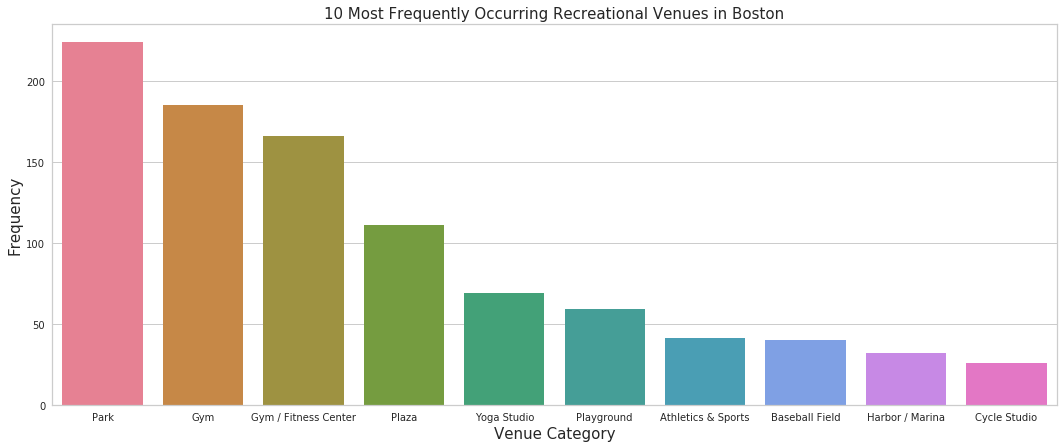

In [15]:
fig = plt.figure(figsize=(18,7))
s=sns.barplot(x="Venue Category", y="Neighborhood",  palette="husl",saturation = 0.75, data=mostpop)
sns.set_context("paper")
s.set_xticklabels(s.get_xticklabels())
plt.title('10 Most Frequently Occurring Recreational Venues in Boston', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
plt.savefig("Most_Freq_Venues.png", dpi=300)
plt.show()

<h4>To begin clustering our neighborhoods and analyzing the types of recreational venues that are most popular in them, perform one-hot encoding to see what categories of venues are present in which neighborhoods.</h4> <h4>Then, we prepare our data for future clustering by grouping our one-hot DataFrame by neighborhood and taking the mean of the frequency of each category. Assign this grouping to a new DataFrame.</h4><h4> Creating a grouped DataFrame in the manner outlined here allows us to use a form of weighting to showcase how significant each category is in each neighborhood.</h4>

In [16]:
boston_onehot = pd.get_dummies(boston_venues[['Venue Category']], prefix="", prefix_sep="")

#add neighborhood names back to dataframe
boston_onehot.rename({"Neighborhood": "Neighborhood Category"}, axis='columns', inplace=True)
boston_onehot['Neighborhood'] = boston_venues['Neighborhood']


# move neighborhood column to the first column
fixed_columns = [boston_onehot.columns[-1] ]+ list(boston_onehot.columns[:-1])
boston_onehot = boston_onehot[fixed_columns]

boston_onehot.head()

,Neighborhood,Athletics & Sports,Baseball Field,Basketball Court,Beach,Bowling Green,Boxing Gym,Campground,Climbing Gym,Cycle Studio,...,State / Provincial Park,Surf Spot,Tennis Court,Track,Trail,Tree,Volleyball Court,Waterfront,Weight Loss Center,Yoga Studio
0,Allston,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Allston,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,Allston,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Allston,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Allston,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
boston_grouped = boston_onehot.groupby('Neighborhood').mean().reset_index()
boston_grouped

,Neighborhood,Athletics & Sports,Baseball Field,Basketball Court,Beach,Bowling Green,Boxing Gym,Campground,Climbing Gym,Cycle Studio,...,State / Provincial Park,Surf Spot,Tennis Court,Track,Trail,Tree,Volleyball Court,Waterfront,Weight Loss Center,Yoga Studio
0,Allston,0.131579,0.026316,0.000000,0.000000,0.00,0.000000,0.026316,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.026316,0.078947
1,Back Bay,0.040000,0.000000,0.000000,0.000000,0.00,0.020000,0.000000,0.000000,0.030000,...,0.00000,0.000000,0.000000,0.000000,0.040000,0.000000,0.00,0.00,0.000000,0.060000
2,Bay Village,0.040000,0.020000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.030000,...,0.00000,0.000000,0.010000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.070000
3,Beacon Hill,0.010000,0.040000,0.010000,0.000000,0.01,0.010000,0.000000,0.000000,0.030000,...,0.00000,0.000000,0.010000,0.000000,0.020000,0.000000,0.00,0.00,0.010000,0.050000
4,Brighton,0.090909,0.045455,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.090909,0.000000,0.00,0.00,0.000000,0.045455
5,Charlestown,0.038462,0.019231,0.019231,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.019231,0.019231,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.096154
6,Chinatown,0.010000,0.020000,0.010000,0.000000,0.00,0.010000,0.000000,0.000000,0.030000,...,0.00000,0.000000,0.010000,0.000000,0.000000,0.000000,0.00,0.00,0.010000,0.060000
7,Dorchester,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.111111,0.000000,0.00,0.00,0.000000,0.111111
8,Downtown,0.010000,0.030000,0.010000,0.000000,0.01,0.000000,0.000000,0.000000,0.030000,...,0.00000,0.000000,0.010000,0.000000,0.020000,0.000000,0.00,0.01,0.010000,0.030000
9,East Boston,0.032258,0.032258,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.032258


<h4>Now that we have our grouped DataFrame, we are interested in knowing what the most frequent recreational venue is in each neighborhood. We will create a visualization for each neighborhood to further our understanding.</h4><h4>This is helpful for those residing in these areas because they can understand what specific venues their neighborhood has the most of.</h4> 

In [18]:
def plotTop5(neighborhood, xcoord, ycoord,hood):
    fig = plt.figure(figsize=(5,3))
    sns.despine(left=True)
    s=sns.barplot(x=xcoord, y=ycoord, data=neighborhood, orient = 'v')
    s.set_xticklabels(s.get_xticklabels(),rotation=40, fontsize = 10)
    plt.title('Top 5 Most Frequent Recreation Venues in {}, Boston'.format(hood), fontsize=12)
    plt.xlabel("Venue Category", fontsize=12)
    plt.ylabel ("Frequency", fontsize=12)
    plt.show()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


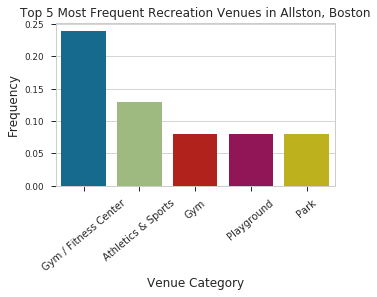

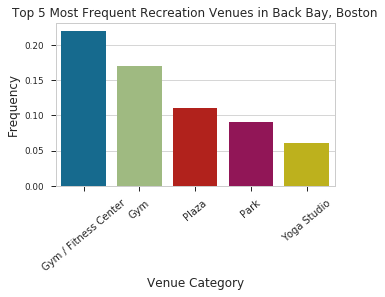

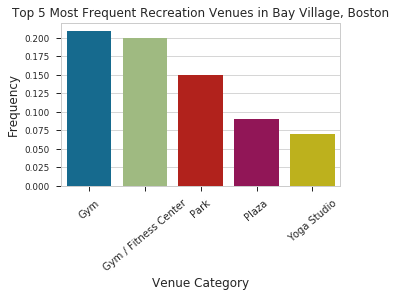

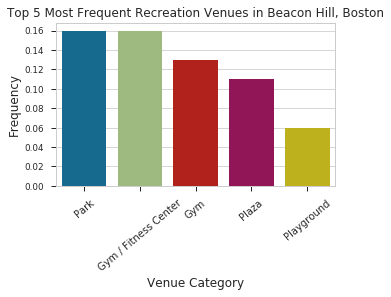

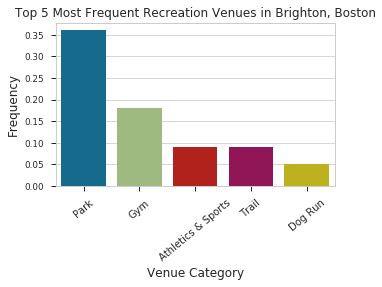

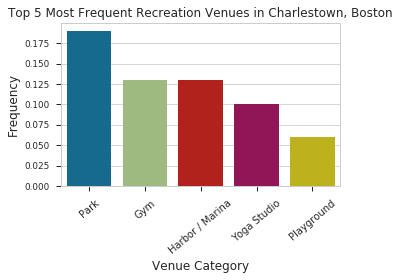

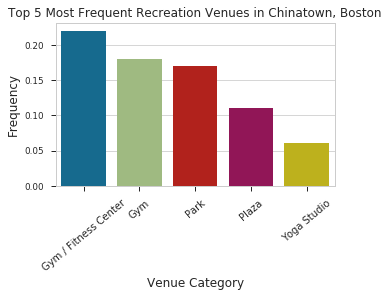

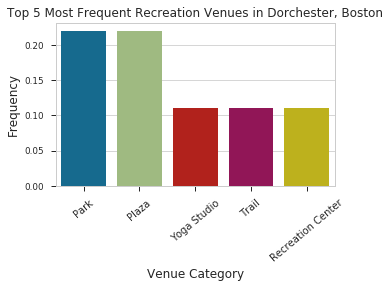

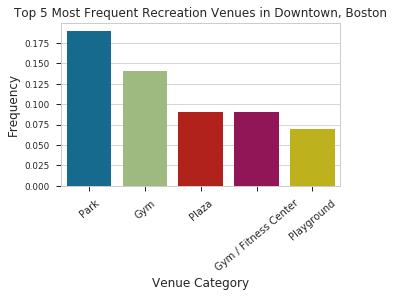

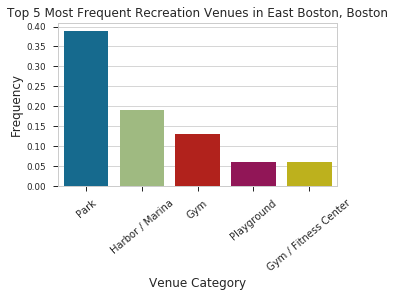

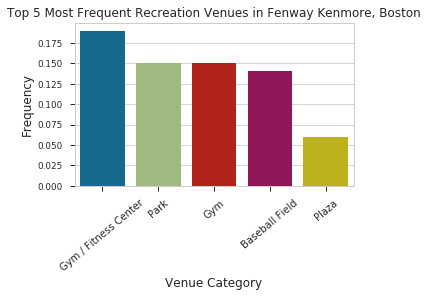

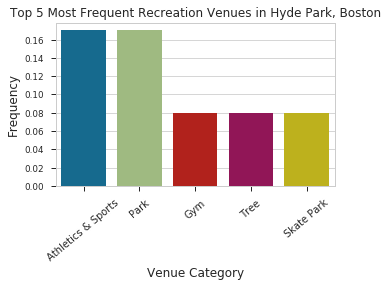

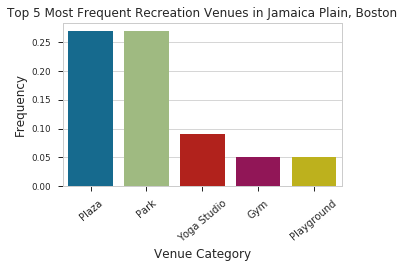

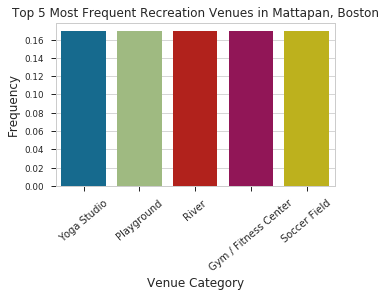

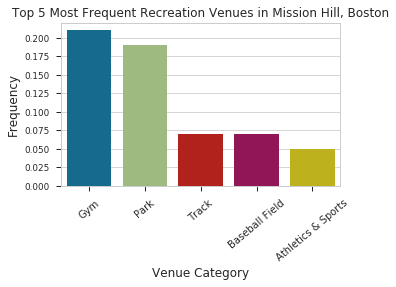

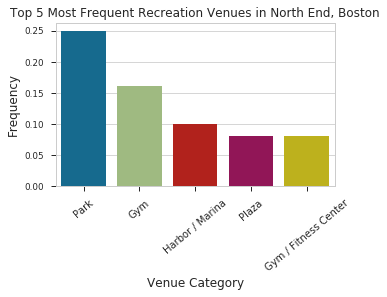

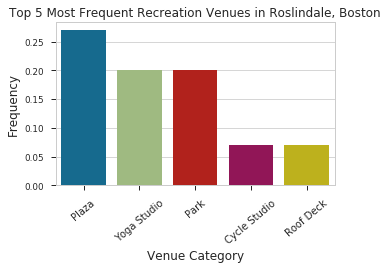

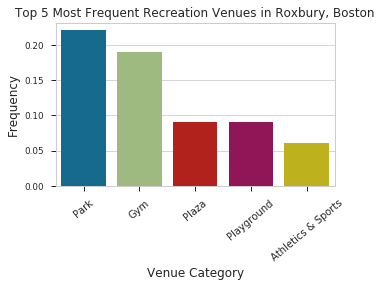

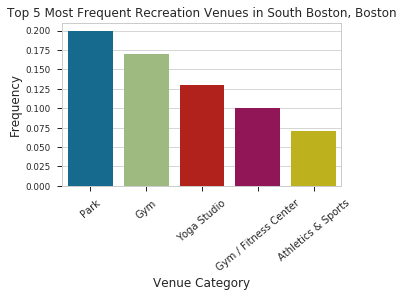

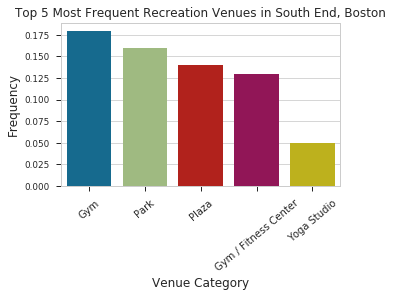

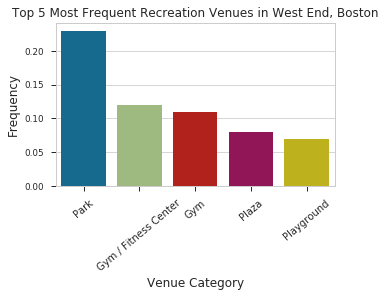

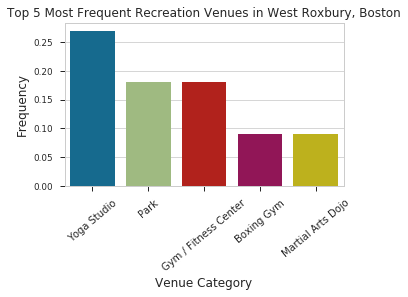

In [19]:
num_top_venues = 5
subplots = 22
for hood in boston_grouped['Neighborhood']:
    temp = boston_grouped[boston_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['Venue','Frequency']
    temp = temp.iloc[1:]
    temp['Frequency'] = temp['Frequency'].astype(float)
    temp = temp.round({'Frequency': 2})
    temp = temp.sort_values('Frequency', ascending=False).reset_index(drop=True).head(num_top_venues)
    temp = temp[0:5]
    plotTop5(temp, 'Venue' , 'Frequency', hood)

<h4>We can store the information on the top 10 venues in each neighborhood into a pandas DataFrame.</h4><h4> This will be helpful later for visualizing what our clusters should approximately be after running K-Means.</h4>

In [20]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [21]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = boston_grouped['Neighborhood']

for ind in np.arange(boston_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(boston_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allston,Gym / Fitness Center,Athletics & Sports,Playground,Gym,Park,Yoga Studio,Martial Arts Dojo,Plaza,Dog Run,Scenic Lookout
1,Back Bay,Gym / Fitness Center,Gym,Plaza,Park,Yoga Studio,Playground,Sculpture Garden,Athletics & Sports,Trail,Cycle Studio
2,Bay Village,Gym,Gym / Fitness Center,Park,Plaza,Yoga Studio,Playground,Athletics & Sports,Cycle Studio,Martial Arts Dojo,Pool
3,Beacon Hill,Gym / Fitness Center,Park,Gym,Plaza,Playground,Yoga Studio,Baseball Field,Cycle Studio,Scenic Lookout,Sculpture Garden
4,Brighton,Park,Gym,Athletics & Sports,Trail,Playground,Baseball Field,Dog Run,Gym / Fitness Center,Harbor / Marina,Yoga Studio


<h4>Now we begin our clustering. First we have to determine which k will produce the best clusters for our data.</h4><h4>We chose to use the Elbow Method in Yellowbrick to visualize which k would be the best for our data.</h4>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


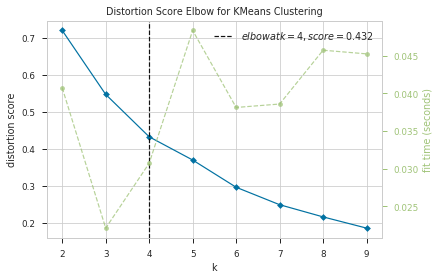

In [22]:
#elbow method to determine best cluster numbers
model = KMeans()
boston_grouped_clustering = boston_grouped.drop('Neighborhood', 1)
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(boston_grouped_clustering)        # Fit the data to the visualizer
visualizer.show() 

<h4>The visualization generated by Yellowbrick indicated that a k value of 4 would produce the most effective clusters for our data.</h4><h4>We will be running our K-means clustering algorithm on our weighted boston_grouped DataFrame with this k value after removing the Neighborhood name from the DataFrame.</h4>
<h4>After we generate our cluster labels, we will add them to our Top 10 Venues DataFrame. Again, this will make it easier for us to understand how k-means clustered our neighborhoods in the future.</h4>

In [23]:
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(boston_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 1, 0, 0, 1, 2, 0, 0], dtype=int32)

In [24]:
# add clustering labels

#uncomment this line if running block again
#neighborhoods_venues_sorted.drop(columns =['Cluster Labels'], axis = 1, inplace=True)

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

boston_merged = df

# merge boston_grouped with df to add latitude/longitude for each neighborhood
boston_merged = boston_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

boston_merged

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allston,42.355434,-71.132127,1,Gym / Fitness Center,Athletics & Sports,Playground,Gym,Park,Yoga Studio,Martial Arts Dojo,Plaza,Dog Run,Scenic Lookout
1,Back Bay,42.350707,-71.079730,1,Gym / Fitness Center,Gym,Plaza,Park,Yoga Studio,Playground,Sculpture Garden,Athletics & Sports,Trail,Cycle Studio
2,Bay Village,42.350011,-71.066948,1,Gym,Gym / Fitness Center,Park,Plaza,Yoga Studio,Playground,Athletics & Sports,Cycle Studio,Martial Arts Dojo,Pool
3,Beacon Hill,42.358708,-71.067829,1,Gym / Fitness Center,Park,Gym,Plaza,Playground,Yoga Studio,Baseball Field,Cycle Studio,Scenic Lookout,Sculpture Garden
4,Brighton,42.350097,-71.156442,0,Park,Gym,Athletics & Sports,Trail,Playground,Baseball Field,Dog Run,Gym / Fitness Center,Harbor / Marina,Yoga Studio
5,Charlestown,42.377875,-71.061996,0,Park,Gym,Harbor / Marina,Yoga Studio,Playground,Skating Rink,Gym / Fitness Center,National Park,Pool,Athletics & Sports
6,Chinatown,42.351329,-71.062623,1,Gym / Fitness Center,Gym,Park,Plaza,Yoga Studio,Playground,Cycle Studio,Sculpture Garden,Baseball Field,Martial Arts Dojo
7,Dorchester,42.297320,-71.074495,2,Plaza,Park,Yoga Studio,Golf Course,Trail,Recreation Center,Gym,Martial Arts Dojo,Lake,Hockey Rink
8,Downtown,42.362918,-71.068737,0,Park,Gym,Plaza,Gym / Fitness Center,Playground,Scenic Lookout,River,Yoga Studio,Dog Run,Cycle Studio
9,East Boston,42.375097,-71.039217,0,Park,Harbor / Marina,Gym,Gym / Fitness Center,Playground,Yoga Studio,Sports Club,Baseball Field,Skate Park,Athletics & Sports


<h2>4. Results</h2>

<h4>Now that our clustering is complete, we will create a visualization of Boston with our clusters. The clusters of neighborhoods are differentiated by color.</h4>

In [25]:
# create map
map_clusters = folium.Map(location=[lat, long], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)+1))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(boston_merged['Latitude'], 
                                  boston_merged['Longitude'], 
                                  boston_merged['Neighborhood'], 
                                  boston_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ': Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<h4>Let's take a look at each cluster to understand how regions of Boston can be grouped by their fitness options.</h4>

In [26]:
boston_merged.loc[boston_merged['Cluster Labels'] == 0, boston_merged.columns[[0] + list(range(4, boston_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Brighton,Park,Gym,Athletics & Sports,Trail,Playground,Baseball Field,Dog Run,Gym / Fitness Center,Harbor / Marina,Yoga Studio
5,Charlestown,Park,Gym,Harbor / Marina,Yoga Studio,Playground,Skating Rink,Gym / Fitness Center,National Park,Pool,Athletics & Sports
8,Downtown,Park,Gym,Plaza,Gym / Fitness Center,Playground,Scenic Lookout,River,Yoga Studio,Dog Run,Cycle Studio
9,East Boston,Park,Harbor / Marina,Gym,Gym / Fitness Center,Playground,Yoga Studio,Sports Club,Baseball Field,Skate Park,Athletics & Sports
14,Mission Hill,Gym,Park,Baseball Field,Track,Yoga Studio,Scenic Lookout,Gym / Fitness Center,Playground,Plaza,Athletics & Sports
15,North End,Park,Gym,Harbor / Marina,Gym / Fitness Center,Plaza,Sculpture Garden,Athletics & Sports,Cycle Studio,Garden,Playground
17,Roxbury,Park,Gym,Playground,Plaza,Athletics & Sports,Skating Rink,Baseball Field,Track,Basketball Court,Gym / Fitness Center
20,West End,Park,Gym / Fitness Center,Gym,Plaza,Playground,Yoga Studio,Sculpture Garden,Scenic Lookout,Athletics & Sports,Trail


In [27]:
boston_merged.loc[boston_merged['Cluster Labels'] == 1, boston_merged.columns[[0] + list(range(4, boston_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allston,Gym / Fitness Center,Athletics & Sports,Playground,Gym,Park,Yoga Studio,Martial Arts Dojo,Plaza,Dog Run,Scenic Lookout
1,Back Bay,Gym / Fitness Center,Gym,Plaza,Park,Yoga Studio,Playground,Sculpture Garden,Athletics & Sports,Trail,Cycle Studio
2,Bay Village,Gym,Gym / Fitness Center,Park,Plaza,Yoga Studio,Playground,Athletics & Sports,Cycle Studio,Martial Arts Dojo,Pool
3,Beacon Hill,Gym / Fitness Center,Park,Gym,Plaza,Playground,Yoga Studio,Baseball Field,Cycle Studio,Scenic Lookout,Sculpture Garden
6,Chinatown,Gym / Fitness Center,Gym,Park,Plaza,Yoga Studio,Playground,Cycle Studio,Sculpture Garden,Baseball Field,Martial Arts Dojo
10,Fenway Kenmore,Gym / Fitness Center,Gym,Park,Baseball Field,Plaza,Yoga Studio,Sculpture Garden,Garden,Athletics & Sports,Trail
11,Hyde Park,Athletics & Sports,Park,Skate Park,Baseball Field,Gym,Gym / Fitness Center,Plaza,Recreation Center,Yoga Studio,Tree
18,South Boston,Park,Gym,Yoga Studio,Gym / Fitness Center,Beach,Athletics & Sports,Track,Climbing Gym,Playground,Plaza
19,South End,Gym,Park,Plaza,Gym / Fitness Center,Yoga Studio,Playground,Cycle Studio,Dog Run,Athletics & Sports,Pilates Studio
21,West Roxbury,Yoga Studio,Gym / Fitness Center,Park,Gym,Boxing Gym,Plaza,Martial Arts Dojo,Basketball Court,National Park,Lake


In [28]:
boston_merged.loc[boston_merged['Cluster Labels'] == 2, boston_merged.columns[[0] + list(range(4, boston_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Dorchester,Plaza,Park,Yoga Studio,Golf Course,Trail,Recreation Center,Gym,Martial Arts Dojo,Lake,Hockey Rink
12,Jamaica Plain,Park,Plaza,Yoga Studio,Gym / Fitness Center,Trail,Pedestrian Plaza,Playground,Cycle Studio,Lake,Harbor / Marina
16,Roslindale,Plaza,Yoga Studio,Park,Scenic Lookout,Trail,Cycle Studio,Pool,Roof Deck,Basketball Court,Lake


In [29]:
boston_merged.loc[boston_merged['Cluster Labels'] == 3, boston_merged.columns[[0] + list(range(4, boston_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Mattapan,Yoga Studio,Playground,Plaza,River,Gym / Fitness Center,Soccer Field,Garden,Lake,Hockey Rink,Hockey Field


<h4>Cluster 1 contains neighborhoods in Boston that have very high numbers of plazas and parks, ideal for someone who likes to keep fit in an open public space.</h4><h4> Cluster 2 contains neighborhoods with high numbers of gyms and fitness centers which would be ideal for those looking to train in a traditional gym setting.</h4><h4> Cluster 3 contains the neighborhood Mattapan, where the most frequent recreational venue is a yoga studio. It should also be noted that the weighting for the top 5 venues for this neighborhood all had equal weight, which could have contributed to why this neighborhood got its own cluster.</h4><h4>Finally, Cluster 4 has neighborhoods with an extensive number of parks, an ideal situation for those who like to stay fit outside.</h4>

<h2>Sources</h2>
<ol style="font-size:18px"> <li>https://www.nhs.uk/live-well/exercise/exercise-health-benefits/</li>
<li>https://adaa.org/living-with-anxiety/managing-anxiety/exercise-stress-and-anxiety</li></ol>